# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

Import Libraries

In [76]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from ht_sim import sim1d




Define the constants and initial conditions

In [77]:
# Geometry
length = 1e-2                 # Length of the rod

# Material properties
rho = 2760.0                      # Density of AL380 (kg/m^3)
rho_l = rho
rho_s = rho *1.5
rho_m = rho
k = 150.0                        # W/m-K
k_l = k                        # W/m-K
k_s = k                        # W/m-K
k_m = k                        # W/m-K
cp = 963.0                        # Specific heat of aluminum (J/kg-K)
cp_l = cp
cp_s = cp
cp_m = cp
alpha = k / (rho * cp)            # Thermal diffusivity
alpha_l = alpha
alpha_s = alpha
aplha_m = alpha
print('alpha ia',alpha)
#L_fusion = 3.9e3                 # J/kg
L_fusion = 389e3               # J/kg

# Spatial discretization

num_points = 50                  # Number of spatial points
dx = length / (num_points - 1)
print('dx is',dx)
                                   #dt = time_end/num_steps
#num_steps = 200000               # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
# Time Discretization  
# 
time_end = 50                # seconds                         
#num_steps = 10000
# dt = time_end/num_steps
dt = abs(0.5 *(dx**2/alpha))
print('dt is ',dt)
num_steps = round(time_end/dt) +1
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/alpha)
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha ia 5.6435956476590365e-05
dx is 0.00020408163265306123
dt is  0.0003689962515618493
num_steps is 135504
cfl is 0.0003689962515618493
stability criteria satisfied


### Initial and Boundary Conditions

In [78]:
# Initial Conditions
T_L = 889.0                       #  K -Liquidus Temperature (616 c) AL 356
T_S = T_L - 338.3                      # K- Solidus Temperature (538 C)


# Initial temperature and phase fields
temperature = np.full(num_points, 890.0)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1.0

temperature[0] = 313.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

#print(temperature_history,phi_history)

Solving the heat transfer equation and phase change using numerical methods

In [79]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
    for n in range(1,num_points-1):              # space loop, adjusted range
        #print(f"Step {m}, point {n},Temperature: {temperature}, Phase: {phase}")
        if temperature[n] >= T_L:
            temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
            phase[n] = 0
         
            #print(m,n,temperature[n],phase[n])
        elif T_S < temperature[n] < T_L:
            #temperature[n] = temperature[n] - (((k * dt) / (rho*(T_L-T_S)*(cp*(T_L-T_S)-L_fusion)*(dx**2))) * (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
            temperature[n] = temperature[n] - ((k/(rho*(cp-(L_fusion/(T_L-T_S)))))* (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
            #print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<T_S:
            temperature[n] = temperature[n] + ((alpha * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
            phase[n] = 1
            
        else:
            print("ERROR: should not be here")
         
           # print(m,n,temperature[n],phase[n])
    
    temperature_history.append(temperature.copy())
    phi_history.append(phase.copy())
    #Print for debugging
    #print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")


#print(temperature_history)
#print(phi_history)




Using max function for removing the if and else framework

 Finite difference method

for m in range(1, num_steps+1):                  # time loop
                # space loop, adjusted range
        
    temp_n = temperature[1:num_points-1]
    #print('temp_n is',temp_n)
    c1_val = np.maximum(temp_n - T_L,0) / np.where(temp_n- T_L!=0, temp_n - T_L, 1)
    c1_val = np.where(c1_val == 0, 0, c1_val)
    #print('c1_val is',c1_val)   
    c2_val = np.maximum(T_S - temp_n,0) / np.where(T_S - temp_n!=0, T_S - temp_n, 1)
    c2_val = np.where(c2_val == 0, 0, c2_val)
    #print('c2_val is',c2_val)
    c3_val = (1-c1_val)*(1-c2_val)
    c3_val = np.where(c3_val == 0, 0, c3_val)
    #print('c3_val is',c3_val) 
    #d2T_dx2 = (temperature[2:num_points] - 2*temp_n + temperature[0:num_points-2]) / dx**2
    phu = (c1_val*alpha_l)+(c2_val*alpha_s)+(c3_val*(k_m/(rho_m*(cp_m-(L_fusion/(T_L-T_S))))))
    temperature[1:num_points-1] += phu * (dt / dx**2)* (temperature[2:num_points] - 2*temp_n + temperature[0:num_points-2]) 
    phase[1:num_points-1] = np.clip((T_L - temp_n)/(T_L-T_S),0,1)
    
    #print(f" time{m},Temperature: {temperature}, ")
    temperature_history.append(np.round(temperature.copy(),3))
    phi_history.append(np.round(phase.copy(),3))
    #Print for debugging
    


#print(temperature_history)
#print(phi_history)

### Niyama Criteria Calculation

In [80]:

c_lamda = (40.9) *10**(-6 )   #material constant for AL 356

del_Pcr = 1.01 *10**5    # difference between P liquidus and P at critical pressure
u_l = 1.58*10**(-3 )     # dynamic viscosity of liquid
beta = (rho_s - rho_l)/ rho_l 
del_Tf = T_L - T_S
print('del_Tf is',del_Tf)  


g = np.array(np.gradient(temperature_history, axis=1))  #gradient of temperature
t_dot = np.array(np.gradient(temperature_history, axis=0))   #time derivative of temperature
t_dot = np.where(t_dot <= 0, 1e-10, t_dot)   #replace zero values with 1e-10
Main= g /(t_dot**(5/6))                        #Main criterion
Pcr = (del_Pcr/(u_l*beta*del_Tf))**(1/2)     #Critical pressure
Niyama = c_lamda * Main *(Pcr)                   #Niyama criterion
print(Niyama)



del_Tf is 338.29999999999995
[[ 3.12556544e+09  1.56278272e+09  0.00000000e+00 ...  0.00000000e+00
  -1.56278272e+09 -3.12556544e+09]
 [ 1.56278272e+09  1.17208704e+09  5.86043521e+08 ... -7.81391361e+08
  -1.56278272e+09 -1.56278272e+09]
 [ 1.56255546e+09  1.17203019e+09  5.86128726e+08 ... -7.81504990e+08
  -1.17208704e+09 -1.56255546e+09]
 ...
 [ 2.41513392e+08  2.41512572e+08  2.41510520e+08 ... -2.41513014e+08
  -2.41513424e+08 -2.41513424e+08]
 [ 2.41512572e+08  2.41511751e+08  2.41509699e+08 ... -2.41512193e+08
  -2.41512604e+08 -2.41512604e+08]
 [ 2.41511751e+08  2.41510930e+08  2.41508878e+08 ... -2.41511373e+08
  -2.41511783e+08 -2.41511783e+08]]


Plot the Results

Transposed Temperature History Shape: (135505, 50)
Transposed Phi History Shape: (135505, 50)


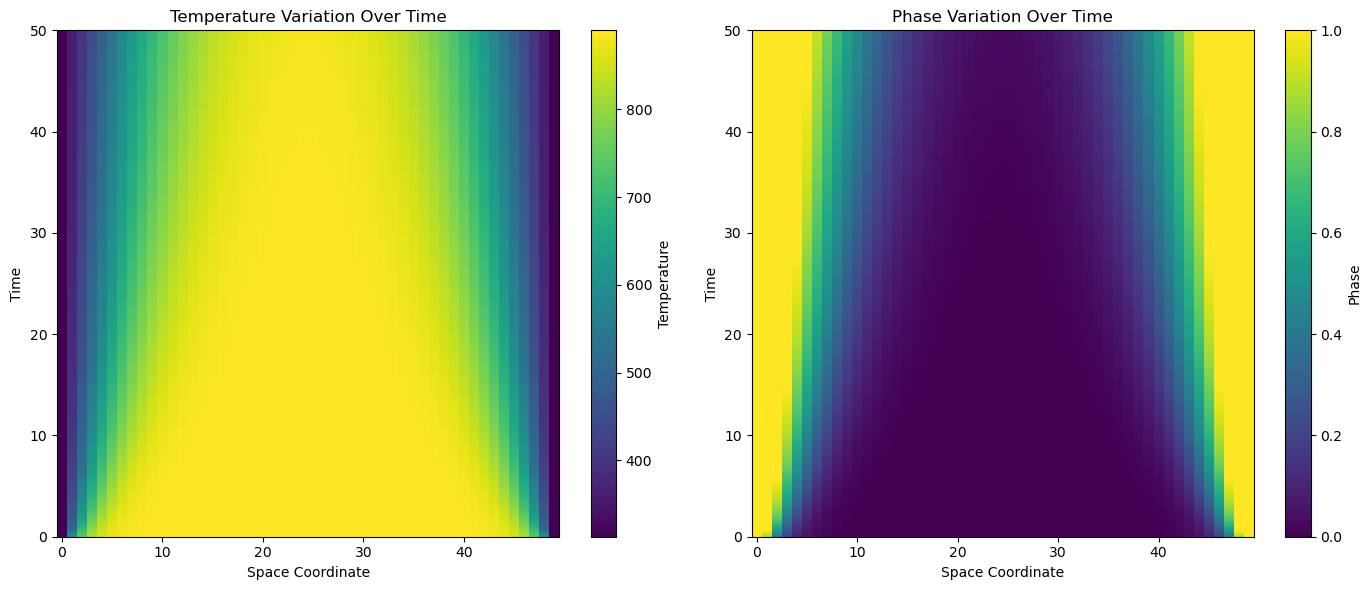

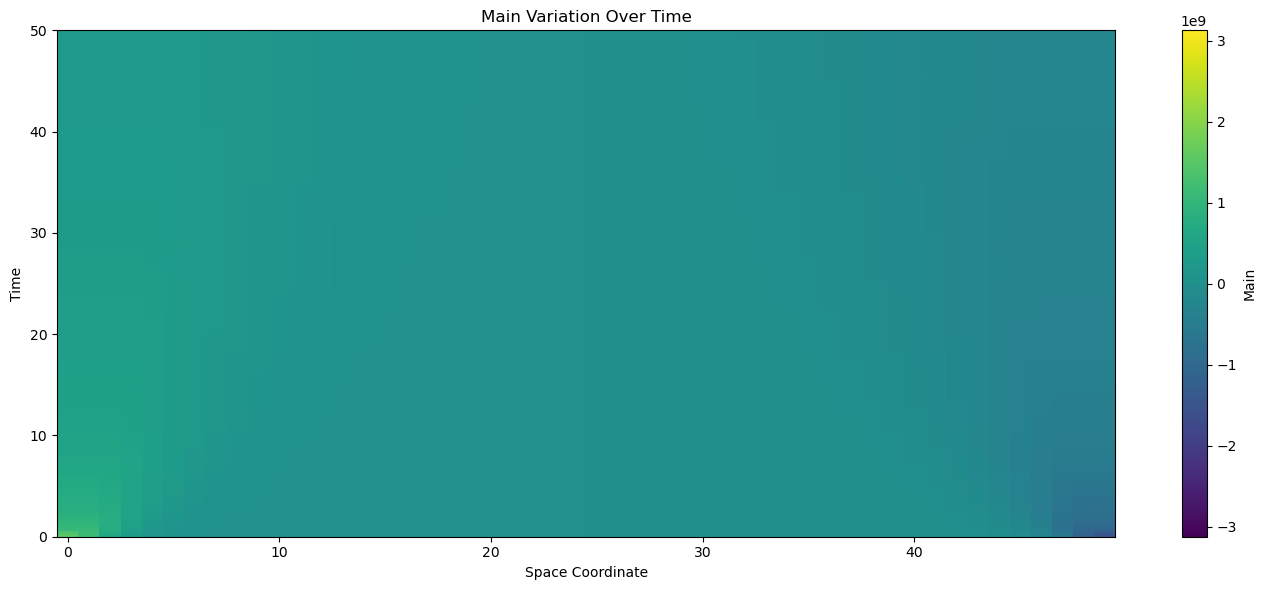

In [81]:
# Assuming you have temperature_history and phi_history as lists of arrays
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)



# Check the new shape after transposing
print("Transposed Temperature History Shape:", temperature_history.shape)
print("Transposed Phi History Shape:", phi_history.shape)

# Create a meshgrid for space and time coordinates
space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))

time_coord = time_coord * dt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
ax1.set_xlabel('Space Coordinate')
ax1.set_ylabel('Time')
ax1.set_title('Temperature Variation Over Time')
fig.colorbar(im1, ax=ax1, label='Temperature')

# Plot the phase history on the right subplot
im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
ax2.set_xlabel('Space Coordinate')
ax2.set_ylabel('Time')
ax2.set_title('Phase Variation Over Time')
fig.colorbar(im2, ax=ax2, label='Phase')
plt.tight_layout()
plt.show()

#plot the main
fig, ax = plt.subplots(figsize=(14, 6))
im = ax.pcolormesh(space_coord, time_coord, Niyama, cmap='viridis')
ax.set_xlabel('Space Coordinate')
ax.set_ylabel('Time')
ax.set_title('Main Variation Over Time')
fig.colorbar(im, ax=ax, label='Main')
plt.tight_layout()
plt.show()

### <center>Pareto analysis</center>

In this section sensitivity study of the soldification and Niyama is performed with respect to different material proerties and their boundary conditions.

A DOE table is created for different factors and their corresponding levels

Here the parameters are as follows:-

Density for material in liquid state $\rho_l$.<br>
Density for material in solid state $\rho_s$.<br>
Latent Heat of Fusion <br>
Specific heat of material in liquid state $C_{pl}$ <br>
Specific heat of material in solid state $C_{ps}$ <br>
Thermal Conductivity of material in liquid state $k_l$<br>
Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
BC at Left end,<br>
BC at Right end<br>

Initial Conditions:-

Initial_temperature

The simualtion of the 1D phase change is give temperature and phase change. The output/ target variable under study here is the Average solidification time of the entire geometry.

If Niyama criteria is being considered then some additional input factors are also considered such as:-

Material constant $C_\lambda$
Dynamic Viscosity $\mu_l$



Create a DOE table for Average Solidification Fraction at time t

In [82]:
import pandas as pd
from pyDOE2 import fullfact

# Create a full factorial design
num_levels = 2
levels = [0, 1]
num_vars = 10
design = fullfact([num_levels]*num_vars)

# Create a DataFrame from the full factorial design
doe_df_sol_time = pd.DataFrame(design, columns=[f'Var_{i}' for i in range(1, num_vars+1)])
print(doe_df_sol_time.shape)

(1024, 10)


In [83]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 10
design2 = fracfact('a b c d e f abcdef abcd bcde adce ')
scale = 1.1
factor_levels = {
    'rho_l': [2760.0, 2760.0 * scale],
    'rho_s': [2760.0, 2760.0 * scale],
    'k_l': [150.0, 150.0 * scale],
    'k_s': [150.0, 150.0 * scale],
    'cp_l': [963.0, 963.0 * scale],
    'cp_s': [963.0, 963.0 * scale],
    'Left_bc': [313.0, 313.0 * scale],
    'right_bc': [400.0, 400.0 * scale],
    'L_fusion': [3.9e3, 3.9e3 * scale],
    'temp_init': [890.0, 890.0 * scale],

}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

(64, 10)


Create a DOE table for Average Dimensionless Niyama Number at time t

In [84]:
# Create a full factorial design
num_levels = 2
levels = [0, 1]
num_vars = 11
design = fullfact([num_levels]*num_vars)

# Create a DataFrame from the full factorial design
doe_df_niyama = pd.DataFrame(design, columns=[f'Var_{i}' for i in range(1, num_vars+1)])
print(doe_df_niyama .shape)

(2048, 11)


In [89]:
Res_doe_sol_time = doe_df_sol_time_fracfact.copy()

Res_doe_sol_time['avg_sol_time'] = [0.0] * Res_doe_sol_time.shape[0]

print(Res_doe_sol_time.head(5))



    rho_l   rho_s    k_l    k_s   cp_l   cp_s  Left_bc  right_bc  L_fusion  \
0  2760.0  2760.0  150.0  150.0  963.0  963.0    344.3     440.0    4290.0   
1  3036.0  2760.0  150.0  150.0  963.0  963.0    313.0     400.0    4290.0   
2  2760.0  3036.0  150.0  150.0  963.0  963.0    313.0     400.0    3900.0   
3  3036.0  3036.0  150.0  150.0  963.0  963.0    344.3     440.0    3900.0   
4  2760.0  2760.0  165.0  150.0  963.0  963.0    313.0     400.0    3900.0   

   temp_init  avg_sol_time  
0      979.0           0.0  
1      890.0           0.0  
2      979.0           0.0  
3      890.0           0.0  
4      890.0           0.0  


Function for simulation

In [86]:
# here the response values are calculated using sim1d function

for i in range(Res_doe_sol_time.shape[0]):
    input_values = Res_doe_sol_time.iloc[i,:-1].values
    Res_doe_sol_time.at[i, 'avg_sol_time'] = sim1d(*input_values)

Anova of the DOE-Soldifcation time

In [87]:
from statsmodels.formula.api import ols
# Create the formula for the ANOVA
formula = 'avg_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Left_bc) + C(right_bc) + C(L_fusion) + C(temp_init)'

# Fit the model
model = ols(formula, data=Res_doe_sol_time).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results
print(anova_results)
print(model.summary())

                sum_sq    df         F    PR(>F)
C(rho_l)      0.000229   1.0  2.956075  0.091391
C(rho_s)      0.000733   1.0  9.441403  0.003347
C(k_l)        0.000227   1.0  2.926832  0.092966
C(k_s)        0.000208   1.0  2.675511  0.107828
C(cp_l)       0.000246   1.0  3.167700  0.080842
C(cp_s)       0.000736   1.0  9.485448  0.003279
C(Left_bc)    0.000385   1.0  4.959381  0.030221
C(right_bc)   0.000160   1.0  2.065759  0.156518
C(L_fusion)   0.000018   1.0  0.227795  0.635126
C(temp_init)  0.000142   1.0  1.834942  0.181292
Residual      0.004114  53.0       NaN       NaN
                            OLS Regression Results                            
Dep. Variable:           avg_sol_time   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     3.974
Date:                Fri, 31 May 2024   Prob (F-statistic):           0.000441
Time:            

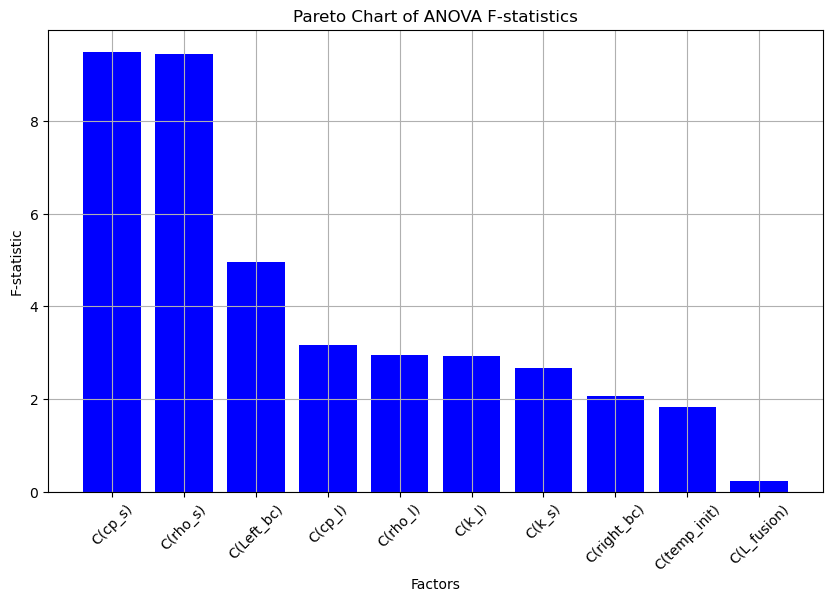

In [88]:
# Create a DataFrame from the ANOVA results
anova_results_df = anova_results.reset_index()

# Sort by the F-statistic or sum of squares for visualization
anova_results_df = anova_results_df.sort_values(by='F', ascending=False)

# Plot the Pareto chart
plt.figure(figsize=(10, 6))
plt.bar(anova_results_df['index'], anova_results_df['F'], color='b')
plt.xlabel('Factors')
plt.ylabel('F-statistic')
plt.title('Pareto Chart of ANOVA F-statistics')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()